In [ ]:
''' First Cell: Single Axonal Area Calculation from PNG Image
    Input: PNG image file path - ENTER PNG FILE PATH after image_path =
    Output: Axon-covered area in µm²'''
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load your PNG file
image_path = "/mnt/Vol20tb1/user_workspaces/shruti/analysis/AxonTracking_MDT2/Detected_Footprints/250512/M08024/000185/BA_12624403860676221272/Well1/TrackingNeuron#12.png"  # Replace with the actual path
img = Image.open(image_path).convert("RGB")
img.show()
# Convert image to numpy array
img_np = np.array(img)

# Convert to grayscale using luminance formula
gray_img = np.dot(img_np[...,:3], [0.2989, 0.5870, 0.1140])

# Apply a grayscale threshold to isolate the signal (tweak this threshold as needed)
threshold = 30  # Adjust if needed
axon_mask = gray_img > threshold

# Estimate pixel size from scale bar: 100 µm ≈ 18 pixels → 1 pixel ≈ 5.56 µm
pixel_size_um = 100 / 18

pixel_area_um2 = pixel_size_um ** 2

# Calculate axonal area
axon_area_um2 = np.sum(axon_mask) * pixel_area_um2

if axon_area_um2 > 800000: 
    print("Detected Neuron")
else: 
    print("No Neuron Detected")
# Output results
print(f"Axon-covered area: {axon_area_um2:.2f} µm²")


Detected Neuron
Axon-covered area: 1036234.57 µm²



(eog:1972179): EOG-WARNING **: 16:30:37.118: Couldn't load icon: Icon 'image-loading' not present in theme Adwaita


## Add Folder Path with Axon Tracking Analysis [project directory] and output directory
### Run it

In [8]:
import os
import re
import shutil
from PIL import Image
import numpy as np
import csv
import pandas as pd

# CONFIGURATION
BASE_DIRS = [
    "/mnt/benshalom-nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/FolicAcid_T4_02252025_SA/FolicAcid_T4_02252025_SA/",
    "/mnt/benshalom-nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/FolicAcid_T4_02252025_SA/FA_remaining/"
]
OUTPUT_DIR = "/mnt/Vol20tb1/user_workspaces/shruti/analysis/FolicAcidT4/AxonAreaAnalysis/"
OUTPUT_CSV = "axon_area_results.csv"
DETECTED_FOOTPRINTS_DIR = os.path.join(OUTPUT_DIR, "Detected_Footprints")

PIXELS_PER_100_UM = 18  # from scale bar
PIXEL_AREA_UM2 = (100 / PIXELS_PER_100_UM) ** 2  # µm² per pixel
THRESHOLD = 30  # threshold (adjust as needed)
DETECTION_THRESHOLD = 800000  # µm² threshold for neuron detection
FOLDER_SUFFIX = "736"  # Folder ending pattern (can be changed)

# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DETECTED_FOOTPRINTS_DIR, exist_ok=True)

def is_target_image(filename):
    """Check if filename matches TrackingNeuron pattern"""
    return re.match(r"TrackingNeuron#\d+\.png", filename)

def extract_metadata(filepath):
    """
    Extract Date, Plate Number, AxonTracking ID, BA identifier, Analysis folder, Well number, Neuron number
    """
    parts = filepath.split(os.sep)
    try:
        # Extract date (6-digit number like 250428)
        date = next((p for p in parts if re.match(r'^\d{6}$', p)), "Unknown")
        
        # Extract plate number (starts with M followed by digits)
        plate_num = next((p for p in parts if re.match(r'^M\d+', p)), "Unknown")
        
        # Extract tracking ID (comes after AxonTracking/)
        tracking_id = parts[parts.index("AxonTracking") + 1] if "AxonTracking" in parts else "Unknown"
        
        # Extract BA identifier (BA_xxxxx...)
        ba_match = next((p for p in parts if p.startswith("BA_")), None)
        ba_id = ba_match if ba_match else "Unknown"
        
        # Extract analysis folder ending in specified suffix (e.g., 272)
        analysis_folder = next((p for p in parts if p.endswith(FOLDER_SUFFIX)), "Unknown")
        
        # Extract well number
        well_match = re.search(r"Well(\d+)", filepath)
        well = f"Well{well_match.group(1)}" if well_match else "Unknown"
        
        # Extract neuron number
        neuron_match = re.search(r"TrackingNeuron#(\d+)", filepath)
        neuron = f"Neuron#{neuron_match.group(1)}" if neuron_match else "Unknown"
        
        return {
            "date": date,
            "plate_num": plate_num,
            "tracking_id": tracking_id,
            "ba_id": ba_id,
            "analysis_folder": analysis_folder,
            "well": well,
            "neuron": neuron
        }
    except Exception as e:
        print(f"Error extracting metadata from {filepath}: {e}")
        return {
            "date": "Unknown",
            "plate_num": "Unknown",
            "tracking_id": "Unknown",
            "ba_id": "Unknown",
            "analysis_folder": "Unknown",
            "well": "Unknown",
            "neuron": "Unknown"
        }

def analyze_image_grayscale(image_path, threshold=THRESHOLD):
    """
    Analyze image using grayscale conversion (luminance formula)
    """
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    
    # Convert to grayscale using luminance formula
    gray_img = np.dot(img_np[...,:3], [0.2989, 0.5870, 0.1140])
    
    # Apply threshold
    axon_mask = gray_img > threshold
    
    pixel_count = np.sum(axon_mask)
    area_um2 = pixel_count * PIXEL_AREA_UM2
    
    return area_um2, pixel_count

def analyze_image_red_channel(image_path, threshold=THRESHOLD):
    """
    Analyze image using red channel (for heatmap visualization)
    """
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    
    # Use red channel as signal indicator
    red_channel = img_np[:, :, 0]
    
    # Apply threshold
    signal_mask = red_channel > threshold
    
    pixel_count = np.sum(signal_mask)
    area_um2 = pixel_count * PIXEL_AREA_UM2
    
    return area_um2, pixel_count

def copy_detected_footprint(source_path, metadata):
    """
    Copy detected footprint to organized folder structure
    """
    # Create nested folder structure
    dest_dir = os.path.join(
        DETECTED_FOOTPRINTS_DIR,
        metadata["date"],
        metadata["plate_num"],
        metadata["tracking_id"],
        metadata["ba_id"],
        metadata["well"]
    )
    os.makedirs(dest_dir, exist_ok=True)
    
    # Copy file
    filename = os.path.basename(source_path)
    dest_path = os.path.join(dest_dir, filename)
    shutil.copy2(source_path, dest_path)
    
    return dest_path

# Main processing
results = []
detected_count = 0
total_count = 0

print("🔍 Starting axon area analysis...")
print(f"Looking for TrackingNeuron#*.png files in {len(BASE_DIRS)} directories...")
print(f"Filtering for folders ending in '{FOLDER_SUFFIX}'...\n")

first_image_tested = False

# Loop through both base directories
for base_idx, BASE_DIR in enumerate(BASE_DIRS):
    print(f"\n{'='*80}")
    print(f"Processing directory {base_idx + 1}/{len(BASE_DIRS)}: {BASE_DIR}")
    print(f"{'='*80}\n")
    
    for root, _, files in os.walk(BASE_DIR):
        for file in files:
            if is_target_image(file):
                # Check if path contains folder ending with specified suffix
                if not any(part.endswith(FOLDER_SUFFIX) for part in root.split(os.sep)):
                    continue
                
                total_count += 1
                full_path = os.path.join(root, file)
                metadata = extract_metadata(full_path)
                
                # Analyze image using grayscale method
                area_um2_gray, pixel_count_gray = analyze_image_grayscale(full_path)
                
                # Analyze image using red channel method
                area_um2_red, pixel_count_red = analyze_image_red_channel(full_path)
                
                # Test first image with both methods
                if not first_image_tested:
                    print("="*80)
                    print("COMPARISON TEST - First Image:")
                    print(f"File: {os.path.basename(full_path)}")
                    print(f"Path: {full_path}")
                    print(f"Grayscale method: {area_um2_gray:.2f} µm² ({pixel_count_gray} pixels)")
                    print(f"Red channel method: {area_um2_red:.2f} µm² ({pixel_count_red} pixels)")
                    print("="*80 + "\n")
                    first_image_tested = True
                
                # Use grayscale method
                area_um2 = area_um2_gray
                pixel_count = pixel_count_gray
                
                # Determine if neuron is detected
                is_detected = area_um2 > DETECTION_THRESHOLD
                detection_status = "Detected Neuron" if is_detected else "No Neuron Detected"
                
                # Copy to Detected_Footprints if detected
                copied_path = None
                if is_detected:
                    detected_count += 1
                    copied_path = copy_detected_footprint(full_path, metadata)
                    print(f"✅ {metadata['date']} | {metadata['plate_num']} | {metadata['ba_id']} | {metadata['well']} | {metadata['neuron']}: {area_um2:.2f} µm² - DETECTED")
                
                results.append({
                    "Date": metadata["date"],
                    "Plate Number": metadata["plate_num"],
                    "Tracking ID": metadata["tracking_id"],
                    "BA ID": metadata["ba_id"],
                    "Analysis Folder": metadata["analysis_folder"],
                    "Well": metadata["well"],
                    "Neuron": metadata["neuron"],
                    "Pixel Count": pixel_count,
                    "Axon Area (µm²)": round(area_um2, 2),
                    "Axon Area Red Channel (µm²)": round(area_um2_red, 2),
                    "Detection Status": detection_status,
                    "Threshold Used": THRESHOLD,
                    "Detection Threshold (µm²)": DETECTION_THRESHOLD,
                    "Copied to Detected Folder": "Yes" if copied_path else "No",
                    "Original Path": full_path
                })

# Convert to DataFrame
df = pd.DataFrame(results)

# Sort by area (descending)
df = df.sort_values("Axon Area (µm²)", ascending=False)

# Save to CSV
csv_path = os.path.join(OUTPUT_DIR, OUTPUT_CSV)
df.to_csv(csv_path, index=False)

# Print summary
print("\n" + "="*80)
print("📊 ANALYSIS SUMMARY")
print("="*80)
print(f"Total images analyzed: {total_count}")
print(f"Neurons detected (>{DETECTION_THRESHOLD} µm²): {detected_count}")
print(f"Detection rate: {(detected_count/total_count*100):.1f}%" if total_count > 0 else "No images found")
print(f"\n✅ Results saved to: {csv_path}")
print(f"📁 Detected footprints copied to: {DETECTED_FOOTPRINTS_DIR}")
print("="*80)

# Preview top 10 results
print("\n🔬 Top 10 Largest Axon Areas:\n")
if not df.empty:
    print(df[["Date", "Plate Number", "BA ID", "Well", "Neuron", "Axon Area (µm²)", "Detection Status"]].head(10).to_string(index=False))
else:
    print("No images found to analyze.")

# Save detected-only CSV
detected_df = df[df["Detection Status"] == "Detected Neuron"]
if not detected_df.empty:
    detected_csv_path = os.path.join(OUTPUT_DIR, "detected_neurons_only.csv")
    detected_df.to_csv(detected_csv_path, index=False)
    print(f"\n✅ Detected neurons only saved to: {detected_csv_path}")
else:
    print(f"\n⚠️ No neurons detected above {DETECTION_THRESHOLD} µm² threshold")

print(f"\n💡 Note: Analysis filtered for folders ending in '{FOLDER_SUFFIX}'")

🔍 Starting axon area analysis...
Looking for TrackingNeuron#*.png files in 2 directories...
Filtering for folders ending in '736'...


Processing directory 1/2: /mnt/benshalom-nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/FolicAcid_T4_02252025_SA/FolicAcid_T4_02252025_SA/

COMPARISON TEST - First Image:
File: TrackingNeuron#1.png
Path: /mnt/benshalom-nas/raw_data/rbs_maxtwo_desktop/harddisk24tbvol1/FolicAcid_T4_02252025_SA/FolicAcid_T4_02252025_SA/250303/M07708/AxonTracking/000016/analysis/AxonAnalysis_v1/BA_12997918808343915736/Well1/TrackingNeuron#1.png
Grayscale method: 1136666.67 µm² (36828 pixels)
Red channel method: 1079012.35 µm² (34960 pixels)

✅ 250303 | M07708 | BA_12997918808343915736 | Well1 | Neuron#1: 1136666.67 µm² - DETECTED
✅ 250303 | M07708 | BA_12997918808343915736 | Well1 | Neuron#2: 817654.32 µm² - DETECTED
✅ 250303 | M07708 | BA_12997918808343915736 | Well1 | Neuron#3: 837191.36 µm² - DETECTED
✅ 250303 | M07708 | BA_12997918808343915736 | Well1 | Neuron#4: 1362

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ============================================================================
# CONFIGURATION - Just point to your CSV file!
# ============================================================================
INPUT_CSV = "/mnt/Vol20tb1/user_workspaces/shruti/analysis/FolicAcidT4/AxonAreaAnalysis/detected_neurons_only.csv"
OUTPUT_DIR = os.path.dirname(INPUT_CSV)  # Save plots in same folder as CSV

# Read data
df = pd.read_csv(INPUT_CSV)

print(f"📊 Loaded {len(df)} detected neurons")
print(f"Columns: {df.columns.tolist()}")
print(f"\nUnique values:")
print(f"  Dates: {sorted(df['Date'].unique())}")
print(f"  Plates: {sorted(df['Plate Number'].unique())}")
print(f"  Wells: {sorted(df['Well'].unique())}\n")

# ============================================================================
# PLOT 1: Total neurons per Date (DIV timeline)
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

date_counts = df.groupby('Date').size().sort_index()
dates = date_counts.index.astype(str)
counts = date_counts.values

bars = ax.bar(range(len(dates)), counts, color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('Date (DIV)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Detected Neurons', fontsize=12, fontweight='bold')
ax.set_title('Detected Neurons Over Time (All Plates)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(dates)))
ax.set_xticklabels(dates, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(counts):
    ax.text(i, v + max(counts)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/1_neurons_per_date.png", dpi=300, bbox_inches='tight')
print("✅ Saved: 1_neurons_per_date.png")
plt.close()

# ============================================================================
# PLOT 2: Neurons per Plate per Date (grouped bars)
# ============================================================================
plate_date_counts = df.groupby(['Date', 'Plate Number']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))
plate_date_counts.plot(kind='bar', ax=ax, width=0.8, edgecolor='black')
ax.set_xlabel('Date (DIV)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Detected Neurons', fontsize=12, fontweight='bold')
ax.set_title('Detected Neurons by Plate Over Time', fontsize=14, fontweight='bold')
ax.legend(title='Plate', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/2_neurons_per_plate_per_date.png", dpi=300, bbox_inches='tight')
print("✅ Saved: 2_neurons_per_plate_per_date.png")
plt.close()

# ============================================================================
# PLOT 3: Neurons per Well (heatmap - Plate x Date x Well)
# ============================================================================
well_counts = df.groupby(['Plate Number', 'Date', 'Well']).size().reset_index(name='Count')
well_pivot = well_counts.pivot_table(
    index=['Plate Number', 'Date'], 
    columns='Well', 
    values='Count', 
    fill_value=0
)

fig, ax = plt.subplots(figsize=(14, max(8, len(well_pivot) * 0.4)))
sns.heatmap(well_pivot, annot=True, fmt='g', cmap='YlOrRd', 
            cbar_kws={'label': 'Neuron Count'}, ax=ax, linewidths=0.5)
ax.set_xlabel('Well', fontsize=12, fontweight='bold')
ax.set_ylabel('Plate | Date', fontsize=12, fontweight='bold')
ax.set_title('Detected Neurons per Well (Heatmap)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/3_neurons_per_well_heatmap.png", dpi=300, bbox_inches='tight')
print("✅ Saved: 3_neurons_per_well_heatmap.png")
plt.close()

# ============================================================================
# PLOT 4: Neurons per Well per Plate (separate subplots for each plate)
# ============================================================================
plates = sorted(df['Plate Number'].unique())
n_plates = len(plates)

fig, axes = plt.subplots(1, n_plates, figsize=(6*n_plates, 6), sharey=True)
if n_plates == 1:
    axes = [axes]

for idx, plate in enumerate(plates):
    plate_data = df[df['Plate Number'] == plate]
    well_counts_plate = plate_data.groupby(['Date', 'Well']).size().unstack(fill_value=0)
    
    well_counts_plate.plot(kind='bar', ax=axes[idx], width=0.8, edgecolor='black')
    axes[idx].set_title(f'{plate}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date (DIV)', fontsize=10)
    axes[idx].set_ylabel('Detected Neurons' if idx == 0 else '', fontsize=10)
    axes[idx].legend(title='Well', fontsize=8, loc='upper left')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Detected Neurons per Well by Plate Over Time', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/4_neurons_per_well_per_plate.png", dpi=300, bbox_inches='tight')
print("✅ Saved: 4_neurons_per_well_per_plate.png")
plt.close()

# ============================================================================
# PLOT 5: Total neurons per Well (collapsed across dates and plates)
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

well_totals = df.groupby('Well').size().sort_index()
wells = well_totals.index
counts_well = well_totals.values

bars = ax.bar(range(len(wells)), counts_well, color='coral', alpha=0.8, edgecolor='black')
ax.set_xlabel('Well', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Detected Neurons', fontsize=12, fontweight='bold')
ax.set_title('Total Detected Neurons per Well (All Plates & Dates)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(wells)))
ax.set_xticklabels(wells, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(counts_well):
    ax.text(i, v + max(counts_well)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/5_total_neurons_per_well.png", dpi=300, bbox_inches='tight')
print("✅ Saved: 5_total_neurons_per_well.png")
plt.close()

# ============================================================================
# PLOT 6: Total neurons per Plate (collapsed across dates and wells)
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))

plate_totals = df.groupby('Plate Number').size().sort_index()
plates_list = plate_totals.index
counts_plate = plate_totals.values

bars = ax.bar(range(len(plates_list)), counts_plate, color='lightgreen', alpha=0.8, edgecolor='black')
ax.set_xlabel('Plate', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Detected Neurons', fontsize=12, fontweight='bold')
ax.set_title('Total Detected Neurons per Plate (All Dates & Wells)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(plates_list)))
ax.set_xticklabels(plates_list, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(counts_plate):
    ax.text(i, v + max(counts_plate)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/6_total_neurons_per_plate.png", dpi=300, bbox_inches='tight')
print("✅ Saved: 6_total_neurons_per_plate.png")
plt.close()

# ============================================================================
# SUMMARY TABLE
# ============================================================================
print("\n" + "="*80)
print("📊 SUMMARY STATISTICS")
print("="*80)

summary = df.groupby(['Date', 'Plate Number']).agg({
    'Neuron': 'count',
    'Well': 'nunique'
}).rename(columns={'Neuron': 'Total Neurons', 'Well': 'Active Wells'})

summary['Neurons per Well'] = (summary['Total Neurons'] / summary['Active Wells']).round(1)
summary = summary.reset_index()

print(summary.to_string(index=False))
print("="*80)

# Save summary table
summary.to_csv(f"{OUTPUT_DIR}/summary_statistics.csv", index=False)
print(f"\n✅ Summary table saved to: summary_statistics.csv")

print(f"\n🎉 All visualizations saved to: {OUTPUT_DIR}")

📊 Loaded 1581 detected neurons
Columns: ['Date', 'Plate Number', 'Tracking ID', 'BA ID', 'Analysis Folder', 'Well', 'Neuron', 'Pixel Count', 'Axon Area (µm²)', 'Axon Area Red Channel (µm²)', 'Detection Status', 'Threshold Used', 'Detection Threshold (µm²)', 'Copied to Detected Folder', 'Original Path']

Unique values:
  Dates: [250303, 250310, 250324, 250407]
  Plates: ['M07137', 'M07708', 'M07865', 'M08032', 'M08068', 'M08092']
  Wells: ['Well1', 'Well2', 'Well3', 'Well4', 'Well5', 'Well6']

✅ Saved: 1_neurons_per_date.png
✅ Saved: 2_neurons_per_plate_per_date.png
✅ Saved: 3_neurons_per_well_heatmap.png
✅ Saved: 4_neurons_per_well_per_plate.png
✅ Saved: 5_total_neurons_per_well.png
✅ Saved: 6_total_neurons_per_plate.png

📊 SUMMARY STATISTICS
  Date Plate Number  Total Neurons  Active Wells  Neurons per Well
250303       M07708             77             6              12.8
250303       M08092             77             6              12.8
250310       M07137            124            

['M08035' 'NBP']
Plate Number  M08035  NBP
Date                     
250417            10    6
250421            16    6
250424            54   15
250428            63   30
250501            62   76
250505            68   73
250508            35   52
250512            64  110
250515            23   56
Plate Number  NBP  DMEM
Date                   
250417          6    10
250421          6    16
250424         15    54
250428         30    63
250501         76    62
250505         73    68
250508         52    35
250512        110    64
250515         56    23


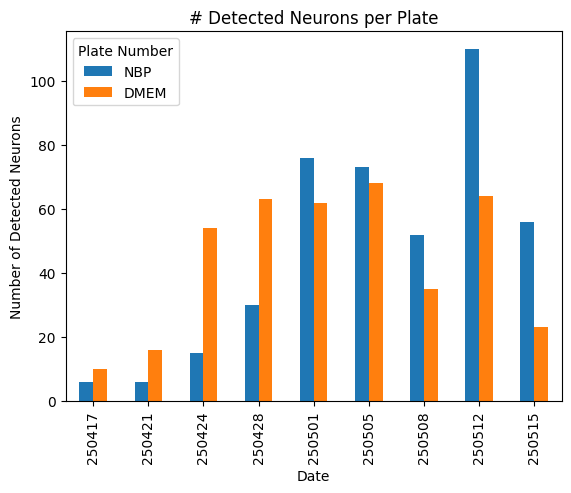

In [52]:
plates = detected_df["Plate Number"].unique()
filtered = detected_df[detected_df["Plate Number"].isin(plates)]
print(detected_df["Plate Number"].unique())
counts = filtered.groupby(["Date", "Plate Number"]).size().unstack(fill_value=0).sort_index()
print(counts)
counts = counts.rename(columns={'M08024': 'NBP', 'M08035': 'DMEM'})
counts = counts[counts.columns[::-1]]
print(counts)

counts.plot(kind='bar')


# Step 6: Add labels
plt.xlabel('Date')
plt.ylabel('Number of Detected Neurons')
plt.title('# Detected Neurons per Plate')
plt.show() 


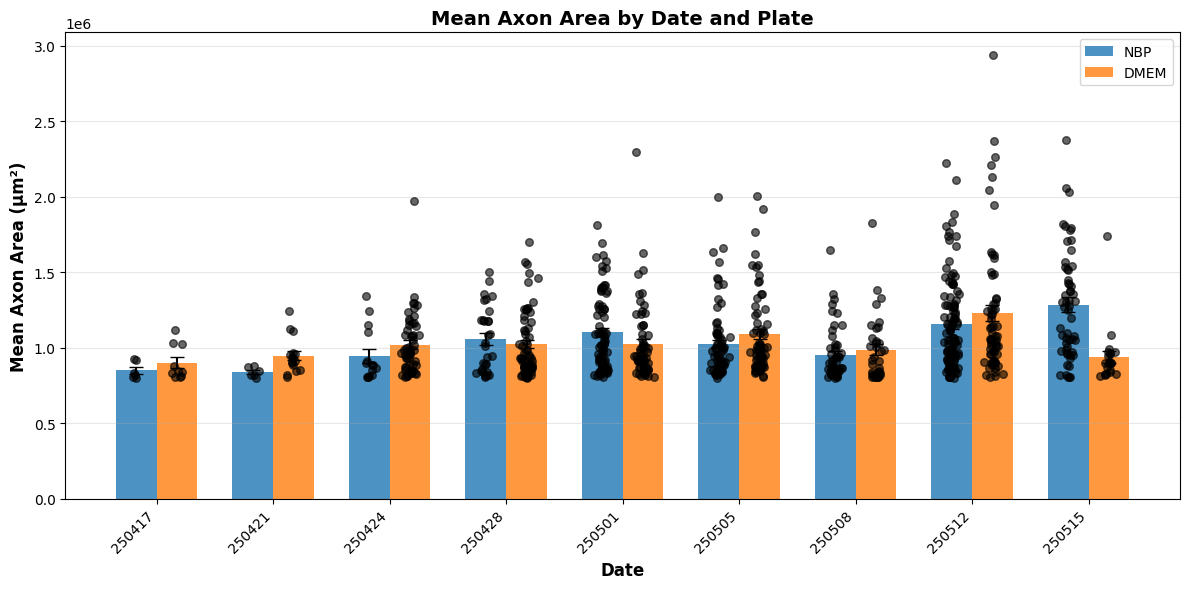


✅ Plot saved!

STATISTICAL COMPARISON (t-test for each date)

Date 250417:
  NBP: 849686.21 ± 22552.05 µm² (n=6)
  DMEM: 898379.63 ± 36411.43 µm² (n=10)
  p-value: 0.3525 ns

Date 250421:
  NBP: 839063.79 ± 13035.41 µm² (n=6)
  DMEM: 945873.84 ± 29485.75 µm² (n=16)
  p-value: 0.0432 *

Date 250424:
  NBP: 945763.37 ± 45215.80 µm² (n=15)
  DMEM: 1020232.62 ± 27417.33 µm² (n=54)
  p-value: 0.1980 ns

Date 250428:
  NBP: 1055470.16 ± 39241.35 µm² (n=30)
  DMEM: 1023562.12 ± 27992.08 µm² (n=63)
  p-value: 0.5147 ns

Date 250501:
  NBP: 1100883.28 ± 29196.24 µm² (n=76)
  DMEM: 1024240.84 ± 32012.69 µm² (n=62)
  p-value: 0.0794 ns

Date 250505:
  NBP: 1023925.25 ± 27554.13 µm² (n=73)
  DMEM: 1087345.68 ± 33030.34 µm² (n=68)
  p-value: 0.1406 ns

Date 250508:
  NBP: 952526.12 ± 24362.64 µm² (n=52)
  DMEM: 987575.84 ± 36912.76 µm² (n=35)
  p-value: 0.4107 ns

Date 250512:
  NBP: 1154001.12 ± 28357.63 µm² (n=110)
  DMEM: 1228048.80 ± 54663.28 µm² (n=64)
  p-value: 0.1865 ns

Date 250515:
  NBP

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Step 1: Read the detected neurons data
df = pd.read_csv('/mnt/Vol20tb1/user_workspaces/shruti/analysis/AxonTracking_MDT2/detected_neurons_only.csv')

# Step 2: Rename plates
df['Plate Number'] = df['Plate Number'].replace({'M08024': 'NBP', 'M08035': 'DMEM'})

# Step 3: Get unique dates
dates = sorted(df['Date'].unique())

# Step 4: Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Step 5: Calculate positions for bars
x_positions = np.arange(len(dates))
width = 0.35  # Width of bars

# Step 6: For each plate, calculate mean and SEM
nbp_means = []
nbp_sems = []
dmem_means = []
dmem_sems = []

for date in dates:
    # NBP data for this date
    nbp_data = df[(df['Date'] == date) & (df['Plate Number'] == 'NBP')]['Axon Area (µm²)']
    nbp_means.append(nbp_data.mean() if len(nbp_data) > 0 else 0)
    nbp_sems.append(nbp_data.sem() if len(nbp_data) > 1 else 0)
    
    # DMEM data for this date
    dmem_data = df[(df['Date'] == date) & (df['Plate Number'] == 'DMEM')]['Axon Area (µm²)']
    dmem_means.append(dmem_data.mean() if len(dmem_data) > 0 else 0)
    dmem_sems.append(dmem_data.sem() if len(dmem_data) > 1 else 0)

# Step 7: Plot bars with error bars
bars1 = ax.bar(x_positions - width/2, nbp_means, width, yerr=nbp_sems, 
               label='NBP', capsize=5, alpha=0.8)
bars2 = ax.bar(x_positions + width/2, dmem_means, width, yerr=dmem_sems,
               label='DMEM', capsize=5, alpha=0.8)

# Step 8: Plot individual data points on top of bars
for i, date in enumerate(dates):
    # NBP points
    nbp_data = df[(df['Date'] == date) & (df['Plate Number'] == 'NBP')]['Axon Area (µm²)']
    if len(nbp_data) > 0:
        x_jitter = np.random.normal(i - width/2, 0.03, len(nbp_data))
        ax.scatter(x_jitter, nbp_data, color='black', s=30, alpha=0.6, zorder=3)
    
    # DMEM points
    dmem_data = df[(df['Date'] == date) & (df['Plate Number'] == 'DMEM')]['Axon Area (µm²)']
    if len(dmem_data) > 0:
        x_jitter = np.random.normal(i + width/2, 0.03, len(dmem_data))
        ax.scatter(x_jitter, dmem_data, color='black', s=30, alpha=0.6, zorder=3)

# Step 9: Labels and formatting
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Axon Area (µm²)', fontsize=12, fontweight='bold')
ax.set_title('Mean Axon Area by Date and Plate', fontsize=14, fontweight='bold')
ax.set_xticks(x_positions)
ax.set_xticklabels(dates, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/mnt/Vol20tb1/user_workspaces/shruti/analysis/AxonTracking_MDT2/', dpi=300)
plt.show()

print("\n✅ Plot saved!")

# Step 10: Add statistics for each date
print("\n" + "="*80)
print("STATISTICAL COMPARISON (t-test for each date)")
print("="*80)

for date in dates:
    nbp_data = df[(df['Date'] == date) & (df['Plate Number'] == 'NBP')]['Axon Area (µm²)']
    dmem_data = df[(df['Date'] == date) & (df['Plate Number'] == 'DMEM')]['Axon Area (µm²)']
    
    if len(nbp_data) > 0 and len(dmem_data) > 0:
        t_stat, p_value = stats.ttest_ind(nbp_data, dmem_data)
        
        sig = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        
        print(f"\nDate {date}:")
        print(f"  NBP: {nbp_data.mean():.2f} ± {nbp_data.sem():.2f} µm² (n={len(nbp_data)})")
        print(f"  DMEM: {dmem_data.mean():.2f} ± {dmem_data.sem():.2f} µm² (n={len(dmem_data)})")
        print(f"  p-value: {p_value:.4f} {sig}")

In [63]:


# For each (Date, Plate Number), keep the row with the largest axon area
df_max = (
    df
    .loc[
        df.groupby(["Date", "Plate Number"])["Axon Area (µm²)"].idxmax()
    ]
    .sort_values(["Date", "Plate Number"])
    .reset_index(drop=True)
)

df_max



,Date,Plate Number,Tracking ID,BA ID,Analysis Folder,Well,Neuron,Pixel Count,Axon Area (µm²),Axon Area Red Channel (µm²),Detection Status,Threshold Used,Detection Threshold (µm²),Copied to Detected Folder,Original Path
0,250417,DMEM,22,BA_12624403860676221272,BA_12624403860676221272,Well2,Neuron#2,36289,1120030.86,1066111.11,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
1,250417,NBP,18,BA_12624403860676221272,BA_12624403860676221272,Well4,Neuron#28,29856,921481.48,901419.75,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
2,250421,DMEM,26,BA_12624403860676221272,BA_12624403860676221272,Well1,Neuron#3,40250,1242283.95,1163518.52,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
3,250421,NBP,31,BA_12624403860676221272,BA_12624403860676221272,Well1,Neuron#20,28472,878765.43,797530.86,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
4,250424,DMEM,40,BA_12624403860676221272,BA_12624403860676221272,Well1,Neuron#5,63824,1969876.54,1911512.35,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
5,250424,NBP,54,BA_12624403860676221272,BA_12624403860676221272,Well1,Neuron#15,43410,1339814.81,1299382.72,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
6,250428,DMEM,78,BA_12624403860676221272,BA_12624403860676221272,Well1,Neuron#9,55058,1699320.99,1667376.54,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
7,250428,NBP,95,BA_12624403860676221272,BA_12624403860676221272,Well2,Neuron#12,48620,1500617.28,1482006.17,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
8,250501,DMEM,108,BA_12624403860676221272,BA_12624403860676221272,Well1,Neuron#13,74476,2298641.98,2288518.52,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
9,250501,NBP,116,BA_12624403860676221272,BA_12624403860676221272,Well6,Neuron#25,58639,1809845.68,1759783.95,Detected Neuron,30,800000,Yes,/mnt/benshalom-nas/analysis/BatchTest/Media_De...
